## Implementing Momentum / RSI Strategy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the data that we compressed into one single file and clear it
data = pd.read_csv("sp500.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
sp500 = data.drop(columns=['Low', 'Open', 'High', 'Close', 'Volume'])

In [4]:
first_100_tickers = sp500['Ticker'].unique()[:100]
sp500 = sp500[sp500['Ticker'].isin(first_100_tickers)]
sp500

,Date,Adjusted Close,Ticker
0,1999-11-18,26.929760,A
1,1999-11-19,24.711119,A
2,1999-11-22,26.929760,A
3,1999-11-23,24.481602,A
4,1999-11-24,25.131901,A
...,...,...,...
824029,2022-12-06,58.250000,D
824030,2022-12-07,58.000000,D
824031,2022-12-08,58.290001,D
824032,2022-12-09,58.279999,D


In [5]:
# Computation of the RSI of all tickers over a 1-week time period here
# period chosen = 7 days for the moment
def rsi(data, window=7):
    différence = data['Adjusted Close'].diff()
    gain = np.where(différence > 0, différence, 0)
    loss = np.where(différence < 0, -différence, 0)
    gain_on_average = pd.Series(gain).rolling(window=window, min_periods=window).mean()
    loss_on_average = pd.Series(loss).rolling(window=window, min_periods=window).mean()
    rs = gain_on_average / loss_on_average
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
# We put the RSI right to the respective ticker
rsi_values = []
for ticker in sp500['Ticker'].unique():
    tickers = sp500[sp500['Ticker'] == ticker]
    ticker_rsi = rsi(tickers)
    rsi_values.extend(ticker_rsi)
sp500['RSI'] = rsi_values
sp500 =sp500.dropna()
sp500

,Date,Adjusted Close,Ticker,RSI
6,1999-11-29,25.782187,A,42.990656
7,1999-11-30,25.820436,A,43.255798
8,1999-12-01,26.279463,A,62.130135
9,1999-12-02,27.006264,A,50.769219
10,1999-12-03,27.235783,A,100.000000
...,...,...,...,...
824029,2022-12-06,58.250000,D,26.114402
824030,2022-12-07,58.000000,D,29.645098
824031,2022-12-08,58.290001,D,40.291567
824032,2022-12-09,58.279999,D,13.256374


In [7]:
# We trade according to the RSI
# O KANE: you buy when momentum signals strenghts (RSI>70) and you sell when it signals weakness (RSI<30) :Weird ??
# So here: Starting with 0 share, we buy one if the RSI is under 30 (stock is oversold by investors) and you sell one if over 70 (stock overbought)
def rsi_trading(data, sell_signal=70, buy_signal=30):
    # Initially,no shares hold at all
    shares = 0 
    pnl = 0  
    cumulative_pnl = [] 
    holding_status = [] 
    daily_returns = [] 
    
    for i in range(len(data)):
        rsi = data.iloc[i]['RSI'] # locate rsi and adj close
        price = data.iloc[i]['Adjusted Close']

        if i == 0:
            daily_return = 0
        else: # computing daily return from the Adj close
            daily_return = (price - data.iloc[i - 1]['Adjusted Close']) / data.iloc[i - 1]['Adjusted Close']
        daily_returns.append(daily_return)
        
        if rsi < buy_signal and shares == 0: # if we have a RSI>30 and previously no share
            shares = 1 # then we buy one -> account for transaction costs (..)
            buy_price = price # the price being the adj close of the day
        elif rsi > sell_signal and shares == 1: # if crosses sell signal + we own one share
            shares = 0 # we sell one (account for TC..)
            pnl += price - buy_price # pnl being the price at which wejust sold - buy_price

        cumulative_pnl.append(pnl) 
        holding_status.append(shares) 

    data['Cumulative PnL'] = cumulative_pnl
    data['Holding Status'] = holding_status
    data['Daily Return'] = daily_returns
    return data

In [8]:
# Now we want to apply this to every stock of the 100 tickers' list
results = []
for ticker in sp500['Ticker'].unique():
    ticker_data = sp500[sp500['Ticker'] == ticker].copy()
    ticker_results = rsi_trading(ticker_data) 
    results.append(ticker_results)
sp500_trading = pd.concat(results)

In [9]:
performance_metrics = sp500_trading.groupby('Ticker').agg(
    Average_PnL=('Cumulative PnL', 'mean'),
    Variance_PnL=('Cumulative PnL', 'var'),
    Average_Daily_Return=('Daily Return', 'mean'),
    Variance_Daily_Return=('Daily Return', 'var')
).reset_index()
print(performance_metrics)

   Ticker  Average_PnL  Variance_PnL  Average_Daily_Return  \
0       A    11.483459    501.273112              0.000659   
1     AAL     9.567027    175.898036              0.000795   
2     AAP    39.579050    935.603862              0.000667   
3    AAPL     3.211073     32.426773              0.001090   
4    ABBV    25.040405    157.572997              0.000940   
..    ...          ...           ...                   ...   
95   CTAS    38.190434   2291.305314              0.000834   
96    CTQ     4.339371      4.379320              0.000032   
97   CTSH    29.271107    826.098375              0.001354   
98    CUK    12.086498    178.072721              0.000392   
99      D    14.465464    300.045335              0.000541   

    Variance_Daily_Return  
0                0.000708  
1                0.001815  
2                0.000431  
3                0.000799  
4                0.000294  
..                    ...  
95               0.000367  
96               0.000042  
97 

In [10]:
# Figures from Apple for instance:
# Avg PNL of $3.21 -> profitable but low.
# Var of PNL: 32.42 -> pretty low.
# Avg of daily returns :0.001090 ->0.109% daily return.
# Var of daily returns: 0.000799 -> pretty stable daily returns.

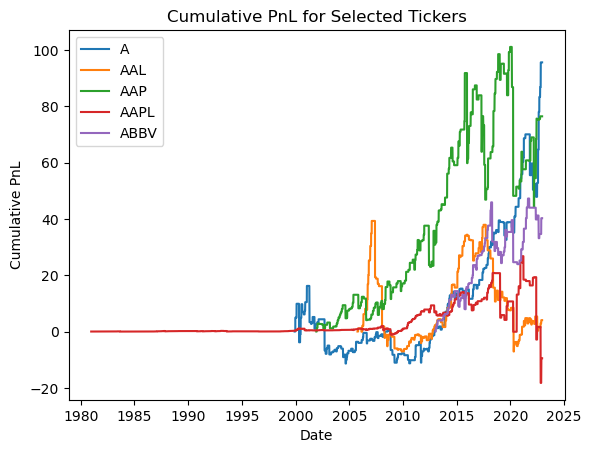

In [11]:
for ticker in sp500['Ticker'].unique()[:5]:
    ticker_data = sp500_trading[sp500_trading['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Cumulative PnL'], label=ticker)

plt.title('Cumulative PnL for Selected Tickers')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

## Combining it with the Moving Averages & then ML

## And we use ML algorithms

In [14]:
# link it to the moving average code + the backtest / ML